In [1]:
%%capture
!pip install nb_black worldview_dl tqdm seaborn

In [2]:
%load_ext lab_black

In [3]:
from intake import open_catalog
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns

import eurec4a

# override matplotlib's default colors with seaborn's
sns.set_color_codes()

In [4]:
# cat = eurec4a.get_intake_catalog()
cat = open_catalog(
    "https://raw.githubusercontent.com/leifdenby/eurec4a-intake/twinotter-microphysics/catalog.yml"
)

# Exploring the Twin-Otter microphysics data

In [5]:
# list the first 10 available files
list(cat.TO.CDP)[:10]

['TO332_1Hz',
 'TO334_1Hz',
 'TO335_1Hz',
 'TO336_1Hz',
 'TO337_1Hz',
 'TO339_1Hz',
 'TO340_1Hz',
 'TO341_1Hz',
 'TO342_1Hz',
 'TO345_1Hz']

In [6]:
# open up data from a single instrument and flight
# cat.TO.CDP.TO332_1Hz.to_dask()

In [7]:
microphysics_instruments = ["FFSSP", "CDP", "2DS", "HVPS"]

In [8]:
# pick a flight for which we know there is data for all instruments
flight_number = 341


def get_available_dataset_for_flight(
    flight_number, instruments=microphysics_instruments
):
    flight_datasets = {}

    for instrument in instruments:
        cat_instrument = cat.TO[instrument]
        flight_identifier = f"TO{flight_number}_1Hz"
        if flight_identifier in cat_instrument:
            ds_inst = cat_instrument[flight_identifier].to_dask()
            ds_inst["instrument"] = instrument
            flight_datasets[instrument] = ds_inst
            # TODO: shouldn't need to add this
            ds_inst.attrs["flight_number"] = flight_number
    return flight_datasets


flight_datasets = get_available_dataset_for_flight(flight_number)
flight_datasets.keys()

dict_keys(['FFSSP', 'CDP', '2DS', 'HVPS'])

We can't simply merge the datasets because each instrument covers different droplet size ranges and has a different number of size bins. Let's have a look at what these size bins are instead :)

In [9]:
flight_datasets["HVPS"]

<xarray.Dataset>
Dimensions:                                      (time: 12701, index: 128)
Coordinates:
  * time                                         (time) datetime64[ns] 2020-0...
Dimensions without coordinates: index
Data variables: (12/14)
    ambient_particle_diameter                    (index) float32 ...
    measurement_channel_lower_limit              (index) float32 ...
    measurement_channel_upper_limit              (index) float32 ...
    ambient_particle_number_per_channel          (time, index) float32 ...
    number_of_instrument_counts_per_channel      (time, index) float32 ...
    qc_flag_ambient_particle_number_per_channel  (time, index) uint32 ...
    ...                                           ...
    month                                        (time) uint32 ...
    day                                          (time) uint32 ...
    hour                                         (time) uint32 ...
    minute                                       (time) uint32 ...
    second                                       (time) float32 ...
    instrument                                   <U4 'HVPS'
Attributes: (12/42)
    source:                                NCAS High Volume Precipitation Spe...
    instrument_manufacturer:               Spec inc., USA
    instrument_model:                      HVPS
    instrument_serial_number:              Not available
    instrument_software:                   spec2d.exe
    instrument_software_version:           Not available
    ...                                    ...
    amf_vocabularies_release:              https://github.com/ncasuk/AMF_CVs/...
    history:                               2020-02-05T00:00:00Z - Data collec...
    comment:                               Data processing was performed to d...
    measurement_technique:                 optical
    Conventions:                           CF-1.6, NCAS-AMF-2.0.0
    flight_number:                         341

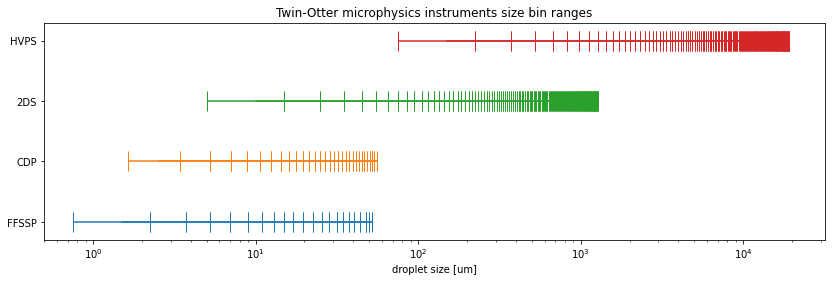

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.set_xscale("log")

for i, instrument in enumerate(microphysics_instruments):
    if not instrument in flight_datasets:
        pass
    ds_inst = flight_datasets[instrument]

    da_bin_minsize = ds_inst.measurement_channel_lower_limit
    da_bin_maxsize = ds_inst.measurement_channel_upper_limit

    assert da_bin_minsize.units == "um"
    da_bin_center = 0.5 * (da_bin_minsize + da_bin_maxsize)
    da_bin_width = da_bin_maxsize - da_bin_minsize

    ax.errorbar(
        x=da_bin_center,
        y=i * np.ones_like(da_bin_center),
        xerr=da_bin_width / 2.0,
        label=instrument,
        capsize=10,
    )

ax.set_yticks(range(len(microphysics_instruments)))
ax.set_yticklabels(microphysics_instruments)
ax.set_xlabel(f"droplet size [um]")
ax.set_xlim(0.5, None)
ax.set_title("Twin-Otter microphysics instruments size bin ranges")
ax.margins(0.1)
fig.set_facecolor("white")
fig.savefig(Path("plots") / "twinotter_mphys_instrument_size_bins.png")

In [11]:
pd.DataFrame(
    [
        (
            inst,
            flight_datasets[inst].measurement_channel_lower_limit.min().item(),
            flight_datasets[inst].measurement_channel_upper_limit.max().item(),
        )
        for inst in microphysics_instruments
    ],
    columns=["instrument", "size minimum [um]", "size maximum [um]"],
)

,instrument,size minimum [um],size maximum [um]
0,FFSSP,0.75000,52.000000
1,CDP,1.63107,55.746269
2,2DS,5.00000,1285.000000
3,HVPS,75.00000,19275.000000


Let's next have a look at plotting using the size bins as the x-coordinate instead of the bin-index

(0.0, 1.2)

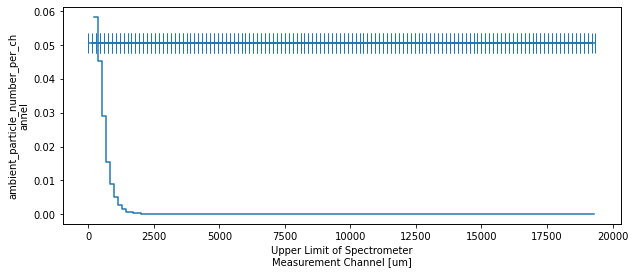

In [12]:
ds_inst = flight_datasets["HVPS"]
da_bin_minsize = ds_inst.measurement_channel_lower_limit
da_bin_maxsize = ds_inst.measurement_channel_upper_limit

ds_inst_bysize = ds_inst.swap_dims(index="measurement_channel_upper_limit")
da_tot_particles_by_size = ds_inst_bysize.ambient_particle_number_per_channel.sum(
    dim="time"
)

fig, ax = plt.subplots(figsize=(10, 4))

da_tot_particles_by_size.plot.step(ax=ax, where="post")

ax_twinx = ax.twinx()
ax_twinx.errorbar(
    x=da_bin_center,
    y=np.ones_like(da_bin_center),
    xerr=da_bin_width,
    label=instrument,
    capsize=10,
)
ax_twinx.set_yticks([])
ax_twinx.set_ylim(0, 1.2)

In [13]:
flight_datasets["HVPS"]

<xarray.Dataset>
Dimensions:                                      (time: 12701, index: 128)
Coordinates:
  * time                                         (time) datetime64[ns] 2020-0...
Dimensions without coordinates: index
Data variables: (12/14)
    ambient_particle_diameter                    (index) float32 150.0 ... 1....
    measurement_channel_lower_limit              (index) float32 75.0 ... 1.9...
    measurement_channel_upper_limit              (index) float32 225.0 ... 1....
    ambient_particle_number_per_channel          (time, index) float32 0.0 .....
    number_of_instrument_counts_per_channel      (time, index) float32 ...
    qc_flag_ambient_particle_number_per_channel  (time, index) uint32 ...
    ...                                           ...
    month                                        (time) uint32 2 2 2 2 ... 2 2 2
    day                                          (time) uint32 5 5 5 5 ... 5 5 5
    hour                                         (time) uint32 16 16 ... 20 20
    minute                                       (time) uint32 30 30 30 ... 1 1
    second                                       (time) float32 19.0 ... 59.0
    instrument                                   <U4 'HVPS'
Attributes: (12/42)
    source:                                NCAS High Volume Precipitation Spe...
    instrument_manufacturer:               Spec inc., USA
    instrument_model:                      HVPS
    instrument_serial_number:              Not available
    instrument_software:                   spec2d.exe
    instrument_software_version:           Not available
    ...                                    ...
    amf_vocabularies_release:              https://github.com/ncasuk/AMF_CVs/...
    history:                               2020-02-05T00:00:00Z - Data collec...
    comment:                               Data processing was performed to d...
    measurement_technique:                 optical
    Conventions:                           CF-1.6, NCAS-AMF-2.0.0
    flight_number:                         341

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TO342 06/02/2020 14:08-17:47\ndistribution of droplet-sizes per instrument during flight'}, xlabel='droplet size [um]', ylabel='total particle number [cm-3]'>)

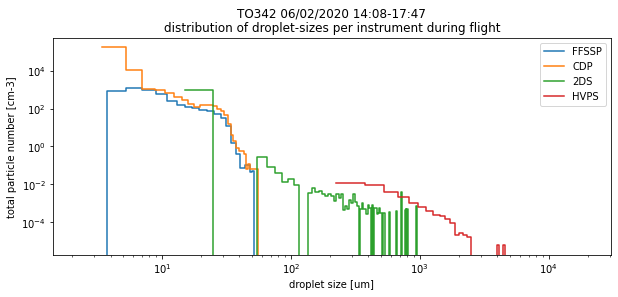

In [14]:
def plot_size_distributions(
    flight_datasets,
    normalized=False,
    ax=None,
    add_title_desc=True,
    line_colors=dict(),
    add_legend=True,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    else:
        fig = ax.figure

    ax.set_xscale("log")
    ax.set_yscale("log")

    for i, instrument in enumerate(microphysics_instruments):
        if not instrument in flight_datasets:
            continue
        ds_inst = flight_datasets[instrument]

        if "ambient_particle_number_per_channel" not in ds_inst.data_vars:
            print(
                f"dataset is missing `ambient_particle_number_per_channel` for instrument {instrument}"
            )
            continue

        ds_inst_bysize = ds_inst.swap_dims(index="measurement_channel_upper_limit")
        da_tot_particles_by_size = (
            ds_inst_bysize.ambient_particle_number_per_channel.sum(dim="time")
        )
        da_tot_particles_by_size.attrs["long_name"] = "total particle number"
        da_tot_particles_by_size.attrs[
            "units"
        ] = ds_inst_bysize.ambient_particle_number_per_channel.units

        ln_kwargs = dict(ax=ax, where="post", label=instrument)
        if instrument in line_colors:
            ln_kwargs["color"] = line_colors[instrument]

        # TODO: this needs fixing in the source data,
        # there shouldn't be any negative values!
        da_tot_particles_by_size = da_tot_particles_by_size.where(
            da_tot_particles_by_size > 0.0
        ).fillna(0.0)

        if not normalized:
            da_tot_particles_by_size.plot.step(**ln_kwargs)

        else:
            da_tot_particles_normalized = (
                da_tot_particles_by_size / da_tot_particles_by_size.sum()
            )

            da_tot_particles_normalized.attrs["units"] = "1/um"
            da_tot_particles_normalized.attrs["long_name"] = "PDF"

            da_tot_particles_normalized.plot.step(**ln_kwargs)

    ax.set_xlabel(f"droplet size [um]")
    if add_legend:
        ax.legend()
    DATETIME_FORMAT = "%d/%m/%Y %H:%M"

    duration_str = (
        f"{ds_inst.time.min().dt.strftime('%d/%m/%Y').data} "
        f"{ds_inst.time.min().dt.strftime('%H:%M').data}-{ds_inst.time.max().dt.strftime('%H:%M').data}"
    )
    title = f"TO{ds_inst.flight_number} {duration_str}"
    if add_title_desc:
        title += "\ndistribution of droplet-sizes per instrument during flight"

    ax.set_title(title)

    return fig, ax


flight_datasets = get_available_dataset_for_flight(342)
plot_size_distributions(flight_datasets, add_legend=True)

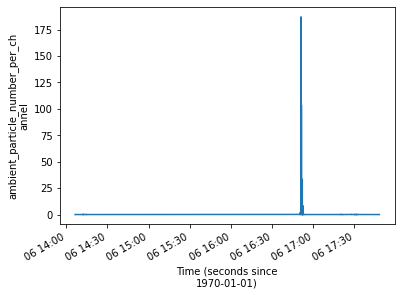

In [15]:
da = flight_datasets["2DS"].ambient_particle_number_per_channel

da_filter = da.where(da > 0.0)
da_filter.sum(dim="index").plot()

Now let's process all flights!

# Droplet size as a function of height

In [16]:
# pick a flight for which we know there is data for all instruments
flight_number = 341

flight_datasets = get_available_dataset_for_flight(
    flight_number,
    instruments=microphysics_instruments
    + [
        "MASIN",
    ],
)
flight_datasets.keys()

dict_keys(['FFSSP', 'CDP', '2DS', 'HVPS', 'MASIN'])

In [17]:
ds_cdp = flight_datasets["CDP"]
ds_masin = flight_datasets["MASIN"]

In [18]:
ds_cdp

<xarray.Dataset>
Dimensions:                                      (time: 12904, index: 30)
Coordinates:
  * time                                         (time) datetime64[ns] 2020-0...
Dimensions without coordinates: index
Data variables:
    ambient_particle_diameter                    (index) float32 ...
    measurement_channel_lower_limit              (index) float32 1.631 ... 53.94
    measurement_channel_upper_limit              (index) float32 3.435 ... 55.75
    ambient_particle_number_per_channel          (time, index) float32 ...
    number_of_instrument_counts_per_channel      (time, index) float32 ...
    qc_flag_ambient_particle_number_per_channel  (time, index) uint32 ...
    instrument                                   <U3 'CDP'
Attributes: (12/42)
    source:                                Manchester Cloud Droplet Probe
    instrument_manufacturer:               Droplet Measurement Technologies, USA
    instrument_model:                      FFSSP
    instrument_serial_number:              Not available
    instrument_software:                   pads.exe
    instrument_software_version:           Not available
    ...                                    ...
    amf_vocabularies_release:              https://github.com/ncasuk/AMF_CVs/...
    history:                               2020-02-05T00:00:00Z - Data collec...
    comment:                               Data processing was performed to d...
    measurement_technique:                 optical
    Conventions:                           CF-1.6, NCAS-AMF-2.0.0
    flight_number:                         341

In [19]:
ds_masin

<xarray.Dataset>
Dimensions:          (time: 13396)
Coordinates:
  * time             (time) datetime64[ns] 2020-02-05T16:17:52 ... 2020-02-05...
Data variables: (12/65)
    TAT_DI_R         (time) float32 ...
    TAT_DI_R_FLAG    (time) float32 ...
    TAT_ND_R         (time) float32 ...
    TAT_ND_R_FLAG    (time) float32 ...
    TDEW_BUCK        (time) float32 ...
    TDEW_BUCK_FLAG   (time) float32 ...
    ...               ...
    V_OXTS_FLAG      (time) float32 ...
    U_OXTS           (time) float32 ...
    U_OXTS_FLAG      (time) float32 ...
    W_OXTS           (time) float32 ...
    W_OXTS_FLAG      (time) float32 ...
    instrument       <U5 'MASIN'
Attributes: (12/22)
    conventions:              CF-1.6
    data_date:                20200205
    title:                    Data from MASIN flight341 on 20200205
    time_coverage_start:      16:17:52 UTC
    time_coverage_end:        20:01:09 UTC
    institution:              BAS - British Antarctic Survey
    ...                       ...
    comment:                  HUM_ROSE is not well calibrated to absolute val...
    version:                  v0.6
    history:                  version created by Leif Denby 2021-05-14T18:45:...
    contact:                  Tom Lachlan-Cope <tlc@bas.ac.uk>, Leif Denby <l...
    acknowledgement:          TO NOT USE FOR PUBLICATION! EARLY-RELEASE DATA
    flight_number:            341

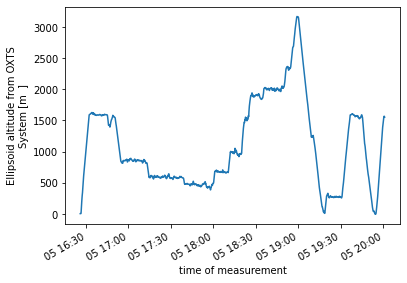

In [20]:
da_masin_alt_interpolated = ds_masin.interp_like(ds_cdp, method="nearest").ALT_OXTS
da_masin_alt_interpolated.plot()

In [21]:
ds_cdp["alt"] = da_masin_alt_interpolated

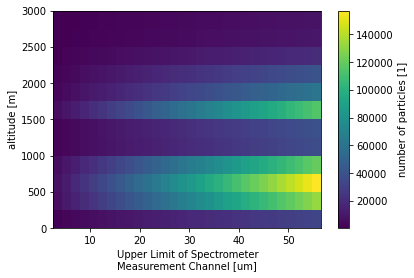

In [22]:
dz_bin = 250
bins = np.arange(0, ds_cdp.alt.max(), dz_bin)

da_tot_n_droplets_by_height = (
    ds_cdp.swap_dims(index="measurement_channel_upper_limit")
    .groupby_bins(ds_cdp.alt, bins=bins)
    .sum()
).ambient_particle_diameter

da_tot_n_droplets_by_height.alt_bins.attrs["units"] = ds_cdp.alt.units.strip()
da_tot_n_droplets_by_height.alt_bins.attrs["long_name"] = "altitude"
da_tot_n_droplets_by_height.attrs["units"] = "1"
da_tot_n_droplets_by_height.attrs["long_name"] = "number of particles"
da_tot_n_droplets_by_height.plot(y="alt_bins")

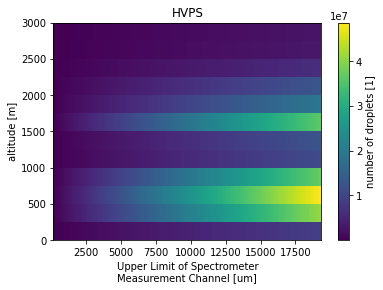

In [23]:
def plot_size_dist_with_height(flight_datasets, instrument, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    ds_mphys = flight_datasets[instrument]
    ds_masin = flight_datasets["MASIN"]

    da_masin_alt_interpolated = ds_masin.interp_like(
        ds_mphys, method="nearest"
    ).ALT_OXTS
    ds_mphys["alt"] = da_masin_alt_interpolated

    dz_bin = 250
    bins = np.arange(0, ds_mphys.alt.max(), dz_bin)

    da_tot_n_droplets_by_height = (
        ds_mphys.swap_dims(index="measurement_channel_upper_limit")
        .groupby_bins(ds_mphys.alt, bins=bins)
        .sum()
    ).ambient_particle_diameter

    da_tot_n_droplets_by_height.alt_bins.attrs["units"] = ds_mphys.alt.units.strip()
    da_tot_n_droplets_by_height.alt_bins.attrs["long_name"] = "altitude"
    da_tot_n_droplets_by_height.attrs["units"] = "1"
    da_tot_n_droplets_by_height.attrs["long_name"] = "number of droplets"
    da_tot_n_droplets_by_height.plot(y="alt_bins", ax=ax)
    ax.set_title(instrument)


plot_size_dist_with_height(flight_datasets=flight_datasets, instrument="HVPS")

Text(0.5, 1.02, 'TO341')

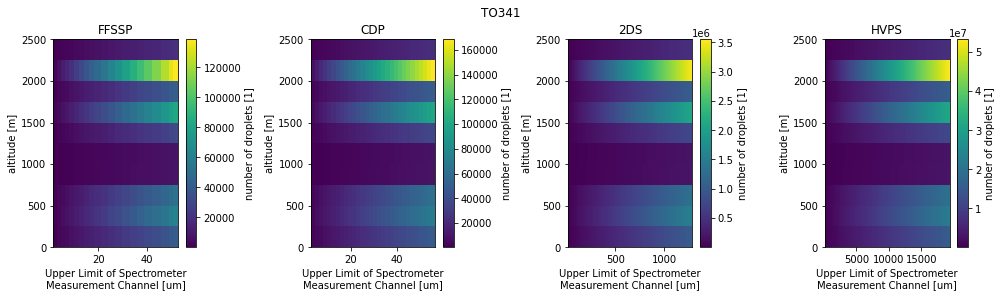

In [24]:
flight_datasets = get_available_dataset_for_flight(
    342,
    instruments=microphysics_instruments
    + [
        "MASIN",
    ],
)

fig, axes = plt.subplots(ncols=4, figsize=(14, 4))

for ax, instrument in zip(axes, microphysics_instruments):
    plot_size_dist_with_height(
        flight_datasets=flight_datasets, instrument=instrument, ax=ax
    )

fig.tight_layout()
fig.suptitle(f"TO{flight_number}", y=1.02)

# Same instrument across entire campaign

  0%|          | 0/24 [00:00<?, ?it/s]

Text(0.5, 1.0, 'CDP\ndistribution of droplet-sizes per instrument per-flight')

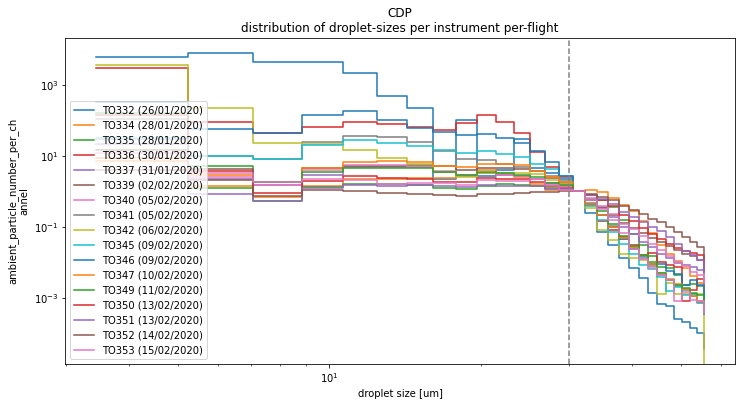

In [25]:
instrument = "CDP"
normalized = "30um_bin"

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xscale("log")
ax.set_yscale("log")

for flight_number in tqdm(list(range(330, 354))):
    flight_datasets = get_available_dataset_for_flight(
        flight_number=flight_number, instruments=[instrument]
    )

    if not instrument in flight_datasets:
        continue
    ds_inst = flight_datasets[instrument]

    if "ambient_particle_number_per_channel" not in ds_inst.data_vars:
        print(
            f"dataset is missing `ambient_particle_number_per_channel` for instrument {instrument}"
        )
        continue

    ds_inst_bysize = ds_inst.swap_dims(index="measurement_channel_upper_limit")
    da_tot_particles_by_size = ds_inst_bysize.ambient_particle_number_per_channel.sum(
        dim="time"
    )

    label = f"TO{flight_number} ({ds_inst.time.min().dt.strftime('%d/%m/%Y').data})"

    if not normalized:
        da_tot_particles_by_size.plot.step(ax=ax, where="post", label=label)

    elif normalized == "30um_bin":
        da_tot_particles_normalized = (
            da_tot_particles_by_size
            / da_tot_particles_by_size.sel(
                measurement_channel_upper_limit=30, method="nearest"
            )
        )
        da_tot_particles_normalized.plot.step(ax=ax, where="post", label=label)

    else:
        da_tot_particles_normalized = (
            da_tot_particles_by_size / da_tot_particles_by_size.sum()
        )

        da_tot_particles_normalized.attrs["units"] = "1/um"
        da_tot_particles_normalized.attrs["long_name"] = "PDF"

        da_tot_particles_normalized.plot.step(ax=ax, where="post", label=label)

ax.set_xlabel(f"droplet size [um]")
ax.legend()

ax.axvline(30, color="grey", linestyle="--")

ax.set_title(f"{instrument}\ndistribution of droplet-sizes per instrument per-flight")

# Creating plots for data paper

## size-distrubutions per-flight
Plot with size distribution for all available instruments for each flight

In [26]:
path_plots = Path("plots/")
normalized = False

for flight_number in [341]:  # tqdm(list(range(330, 354))):
    fn_plot = (
        f"TO{flight_number}.droplet_size_dist{normalized and '_normalized' or ''}.png"
    )
    p_plot = path_plots / fn_plot
    # if p_plot.exists():
    #    continue

    flight_datasets = get_available_dataset_for_flight(flight_number=flight_number)
    if len(flight_datasets) == 0:
        print(f"No data found for flight {flight_number}")
        continue

    fig, ax = plot_size_distributions(
        flight_datasets=flight_datasets, normalized=normalized
    )
    p_plot.parent.mkdir(exist_ok=True, parents=True)
    fig.savefig(p_plot)
    plt.close(fig)
    del fig

  0%|          | 0/14 [00:00<?, ?it/s]

No data found for flight 333
No data found for flight 338
No data found for flight 343
Saved figure to TO_mphys_dropsize_dist_TO330-TO343.png


  0%|          | 0/11 [00:00<?, ?it/s]

dataset is missing `ambient_particle_number_per_channel` for instrument HVPS
No data found for flight 348
Saved figure to TO_mphys_dropsize_dist_TO344-TO354.png


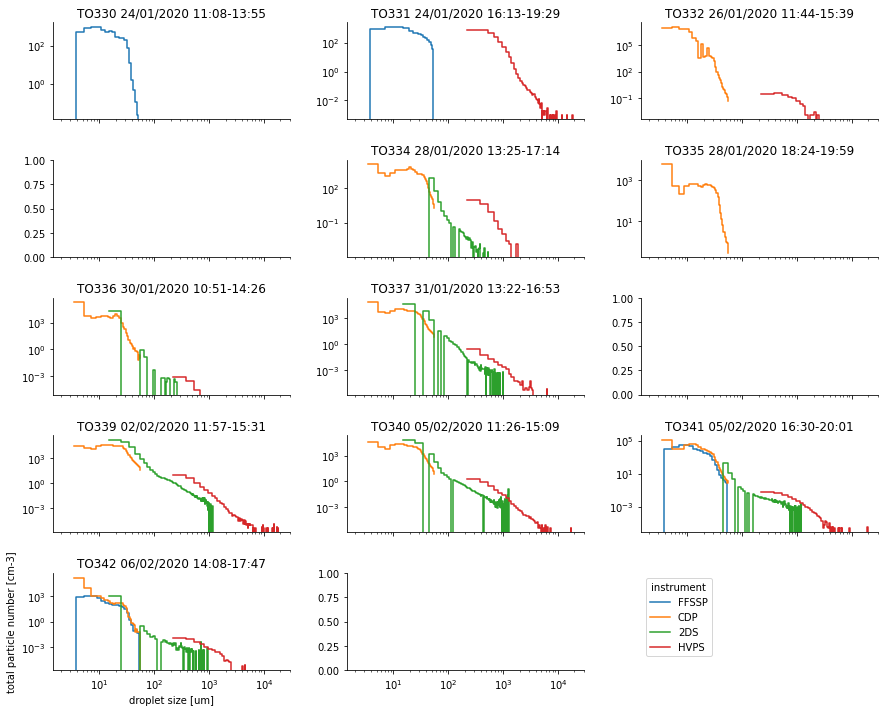

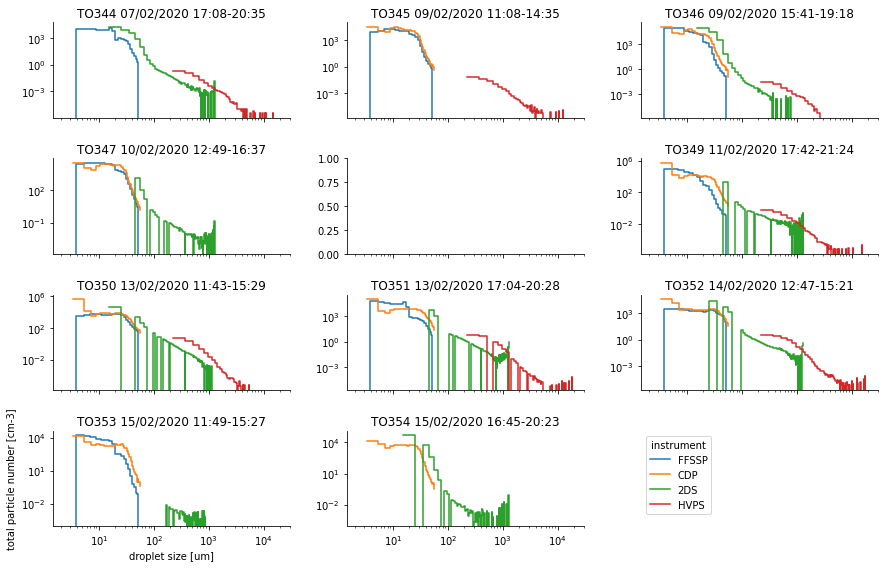

In [27]:
import matplotlib.lines as mpl_lines


def plot_page(flight_numbers):
    # fixed instrument -> color mapping to ensure the instruments
    # have the same color across plots
    line_colors = dict(
        zip(
            microphysics_instruments,
            sns.color_palette(n_colors=len(microphysics_instruments)),
        )
    )

    n_flights_page = len(flight_numbers)
    ncols = 3
    nrows = n_flights_page // ncols
    if nrows * ncols < n_flights_page:
        nrows += 1
    domain_aspect = 0.5
    subfig_width = 4.0

    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(subfig_width * ncols + 0.4, subfig_width * domain_aspect * nrows),
        sharex=True,
        #        sharey=True,
    )

    for ax, flight_number in tqdm(
        zip(axes.flatten(), flight_numbers), total=n_flights_page
    ):
        flight_datasets = get_available_dataset_for_flight(flight_number=flight_number)
        if len(flight_datasets) == 0:
            print(f"No data found for flight {flight_number}")
            continue

        plot_size_distributions(
            flight_datasets=flight_datasets,
            normalized=False,
            ax=ax,
            add_title_desc=False,
            add_legend=False,
            line_colors=line_colors,
        )
    fig.tight_layout()

    # x and y-label on bottom left subplot only
    for ax in axes.flatten():
        if ax != axes[-1, 0]:
            ax.set_ylabel("")
            ax.set_xlabel("")
    sns.despine(fig)

    for ax in axes.flatten()[len(flight_numbers) :]:
        ax.axis("off")

    ax_last = axes[-1, -1]

    ax_last.legend(
        title="instrument",
        *zip(
            *[
                (mpl_lines.Line2D([0], [0], color=color), label)
                for (label, color) in line_colors.items()
            ]
        ),
        loc="upper left",
    )

    fig.set_facecolor("white")

    return fig, axes


flight_numbers = list(range(330, 355))
flights_per_page = [flight_numbers[:14], flight_numbers[14:]]

for page_flight_numbers in flights_per_page:
    fig, axes = plot_page(page_flight_numbers)
    plot_fn = f"TO_mphys_dropsize_dist_TO{page_flight_numbers[0]}-TO{page_flight_numbers[-1]}.png"
    fig.savefig(Path("plots") / plot_fn)
    print(f"Saved figure to {plot_fn}")

# Timeseries

In [28]:
flight_number = 341

flight_datasets = get_available_dataset_for_flight(
    flight_number,
    instruments=microphysics_instruments
    + [
        "MASIN",
    ],
)

In [29]:
# attempt at merging into one xr.Dataset
# NB: doesn't work at the moment


def merge_to_masin_timestamps(flight_number):
    ds_masin = get_available_dataset_for_flight(
        flight_number=flight_number, instruments=["MASIN"]
    )["MASIN"]

    mphys_datasets = get_available_dataset_for_flight(
        flight_number=flight_number, instruments=microphysics_instruments
    )

    mphys_particle_counts = {}

    for (instrument_name, ds_mphys) in mphys_datasets.items():
        mphys_particle_counts[
            instrument_name
        ] = ds_mphys.ambient_particle_number_per_channel.sum(dim="index")
        mphys_particle_counts[instrument_name]["mphys_instrument"] = instrument_name
        mphys_particle_counts[instrument_name]["mphys_instrument"].attrs[
            "long_name"
        ] = "mphys inst"

    mphys_particle_counts_interpolated = {
        name: da_counts.interp_like(ds_masin)
        for (name, da_counts) in mphys_particle_counts.items()
    }

    ds_masin["num_particles"] = xr.concat(
        mphys_particle_counts_interpolated.values(),
        dim="mphys_instrument",
    )

    return ds_masin


ds_masin_with_mphys_counts = merge_to_masin_timestamps(341)

In [30]:
# western side of HALO circle
HALO_CIRCLE_WEST_LON = -(57 + (43 / 60)) - 1


def crop_to_halo_circle(ds_masin):
    da_time_circle = ds_masin.time.where(
        ds_masin_with_mphys_counts.LON_OXTS > HALO_CIRCLE_WEST_LON, drop=True
    )
    da_time_enter_circle = da_time_circle.min()
    da_time_leave_circle = da_time_circle.max()
    return ds_masin.sel(time=slice(da_time_enter_circle, da_time_leave_circle))


ds_masin_with_mphys_counts_in_circle = crop_to_halo_circle(ds_masin_with_mphys_counts)

In [31]:
ds_joanne = cat.dropsondes.JOANNE.level3.to_dask()
ds_joanne

<xarray.Dataset>
Dimensions:            (alt: 1001, sonde_id: 1068, nv: 2)
Coordinates:
  * alt                (alt) int16 0 10 20 30 40 ... 9960 9970 9980 9990 10000
  * sonde_id           (sonde_id) object 'HALO-0119_s02' ... 'P3-0211_s43'
    launch_time        (sonde_id) datetime64[ns] ...
    interpolated_time  (sonde_id, alt) datetime64[ns] ...
    lat                (sonde_id, alt) float32 ...
    lon                (sonde_id, alt) float32 ...
Dimensions without coordinates: nv
Data variables: (12/23)
    p                  (sonde_id, alt) float32 ...
    ta                 (sonde_id, alt) float32 ...
    rh                 (sonde_id, alt) float32 ...
    wspd               (sonde_id, alt) float32 ...
    wdir               (sonde_id, alt) float32 ...
    u                  (sonde_id, alt) float32 ...
    ...                 ...
    N_gps              (sonde_id, alt) float32 ...
    m_p                (sonde_id, alt) float32 ...
    m_ta               (sonde_id, alt) float32 ...
    m_rh               (sonde_id, alt) float32 ...
    m_gps              (sonde_id, alt) float32 ...
    alt_bnds           (alt, nv) int32 ...
Attributes: (12/16)
    title:                   EUREC4A JOANNE Level-3
    doi:                     10.25326/246
    created with:            run_joanne.py doi:10.5281/zenodo.5521192
    Conventions:             CF-1.8
    campaign_id:             EUREC4A
    project_id:              JOANNE
    ...                      ...
    JOANNE_version:          2.0.0
    author:                  Geet George
    author_email:            geet.george@mpimet.mpg.de
    featureType:             trajectory
    reference:               George et al., JOANNE : Joint dropsonde Observat...
    creation_time:           2021-09-22 14:35:24.817595 UTC

In [32]:
def get_joanne_sondes_during_flight(ds_):
    m_during_flight = np.logical_and(
        ds_.time.min() < ds_joanne.launch_time, ds_joanne.launch_time < ds_.time.max()
    )
    ds_joanne_during_flight = ds_joanne.where(m_during_flight, drop=True)
    return ds_joanne_during_flight


get_joanne_sondes_during_flight(ds_masin_with_mphys_counts_in_circle)

<xarray.Dataset>
Dimensions:            (sonde_id: 15, alt: 1001, nv: 2)
Coordinates:
  * alt                (alt) int16 0 10 20 30 40 ... 9960 9970 9980 9990 10000
  * sonde_id           (sonde_id) object 'HALO-0205_s65' ... 'P3-0205_s27'
    launch_time        (sonde_id) datetime64[ns] 2020-02-05T16:58:53 ... 2020...
    interpolated_time  (sonde_id, alt) datetime64[ns] ...
    lat                (sonde_id, alt) float32 ...
    lon                (sonde_id, alt) float32 ...
Dimensions without coordinates: nv
Data variables: (12/23)
    p                  (sonde_id, alt) float32 nan 1.016e+05 ... nan nan
    ta                 (sonde_id, alt) float32 nan 299.9 299.8 ... nan nan nan
    rh                 (sonde_id, alt) float32 nan 0.7392 0.7482 ... nan nan nan
    wspd               (sonde_id, alt) float32 nan 10.14 9.577 ... nan nan nan
    wdir               (sonde_id, alt) float32 nan 74.91 78.9 ... nan nan nan
    u                  (sonde_id, alt) float32 nan -9.788 -9.395 ... nan nan nan
    ...                 ...
    N_gps              (sonde_id, alt) float32 nan 2.0 3.0 2.0 ... nan nan nan
    m_p                (sonde_id, alt) float32 nan 2.0 2.0 2.0 ... nan nan nan
    m_ta               (sonde_id, alt) float32 nan 2.0 2.0 2.0 ... nan nan nan
    m_rh               (sonde_id, alt) float32 nan 2.0 2.0 2.0 ... nan nan nan
    m_gps              (sonde_id, alt) float32 nan 2.0 2.0 2.0 ... nan nan nan
    alt_bnds           (alt, nv, sonde_id) float64 -5.0 -5.0 ... 1.000e+04
Attributes: (12/16)
    title:                   EUREC4A JOANNE Level-3
    doi:                     10.25326/246
    created with:            run_joanne.py doi:10.5281/zenodo.5521192
    Conventions:             CF-1.8
    campaign_id:             EUREC4A
    project_id:              JOANNE
    ...                      ...
    JOANNE_version:          2.0.0
    author:                  Geet George
    author_email:            geet.george@mpimet.mpg.de
    featureType:             trajectory
    reference:               George et al., JOANNE : Joint dropsonde Observat...
    creation_time:           2021-09-22 14:35:24.817595 UTC

In [33]:
def crop_with_offset(ds, offset_minutes, duration_minutes):
    dt_offset = np.timedelta64(offset_minutes, "m")
    dt_window = np.timedelta64(duration_minutes, "m")
    t0 = ds.time.min() + dt_offset
    return ds.sel(time=slice(t0, t0 + dt_window))

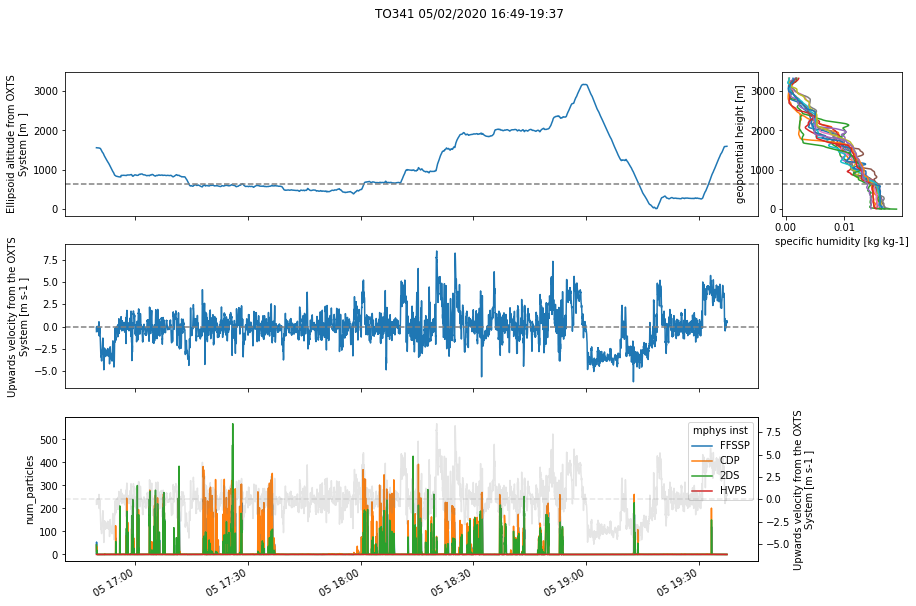

In [34]:
def plot_mphys_and_alt_timeseries(ds_, show_mphys_cumsum=False):
    mosaic = """
    aaaaaj
    bbbbb.
    ccccc.
    """
    fig, axes = plt.subplot_mosaic(mosaic, figsize=(15, 9))

    ax = axes["a"]
    ds_.ALT_OXTS.plot(ax=ax)
    z_cb = 650
    ax.axhline(z_cb, color="grey", linestyle="--")

    z_max = max(ax.get_ylim()[1], 800)

    ax = axes["j"]
    ax.sharey(axes["a"])
    try:
        ds_joanne_during_flight = get_joanne_sondes_during_flight(ds_)
        ds_joanne_during_flight.sel(alt=slice(None, z_max)).q.plot(
            ax=ax, hue="sonde_id", y="alt", add_legend=False
        )
        ax.axhline(z_cb, color="grey", linestyle="--")
    except IndexError:
        pass

    ax = axes["b"]
    ds_.VELZ_OXTS.plot(ax=ax)
    ax.axhline(0.0, color="grey", linestyle="--")

    ax = axes["c"]
    ds_.num_particles.plot(ax=ax, hue="mphys_instrument")

    if show_mphys_cumsum:
        ax = ax.twinx()
        da = ds_segment.num_particles.fillna(0)
        da_ecdf = da.cumsum(dim="time") / da.sum(dim="time")
        da_ecdf.plot(ax=ax, hue="mphys_instrument", add_legend=False)
    else:
        ax = ax.twinx()
        ds_.VELZ_OXTS.plot(ax=ax, color="grey", alpha=0.2)
        ax.axhline(0.0, color="grey", linestyle="--", alpha=0.2)
    [axes[l].set_xlabel("") for l in "abc"]
    [axes[l].set_xticklabels([]) for l in "ab"]

    DATETIME_FORMAT = "%d/%m/%Y %H:%M"

    duration_str = (
        f"{ds_.time.min().dt.strftime('%d/%m/%Y').data} "
        f"{ds_.time.min().dt.strftime('%H:%M').data}-{ds_.time.max().dt.strftime('%H:%M').data}"
    )

    fig.suptitle(f"TO{ds_.flight_number} {duration_str}")

    # axes["c"].set_ylim(0, 10)


ds_masin_with_mphys_counts = merge_to_masin_timestamps(341)
ds_masin_with_mphys_counts_in_circle = crop_to_halo_circle(ds_masin_with_mphys_counts)
ds_segment = crop_with_offset(
    ds_masin_with_mphys_counts_in_circle, offset_minutes=0, duration_minutes=300
)
# ds_segment = ds_segment.sel(mphys_instrument=["HVPS"])
plot_mphys_and_alt_timeseries(ds_segment, show_mphys_cumsum=False)

TODO:

- [ ] missing flight_number attribute
- [ ] negative values for some files